In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

Os dados estão divididos em train(8mi de linhas), validation(10% do train) e test(2mi de linhas).

In [2]:
%%time

dtype = {
    'ip':'int32',
    'app': 'int16',
    'device': 'int16',
    'os': 'int16',
    'channel': 'int16',
    'is_attributed':'int8'
}

train = pd.read_csv("train.csv", nrows=8000000, parse_dates=['click_time', 'attributed_time'], dtype=dtype)

Wall time: 31.9 s


In [3]:
train['ct_day'] = train.click_time.dt.day.astype('uint8')
train['ct_weekday'] = train.click_time.dt.weekday.astype('uint8')
train['ct_hour'] = train.click_time.dt.hour.astype('uint8')

y = train['is_attributed']
train.drop(['is_attributed', 'attributed_time', 'click_time'], axis=1, inplace=True)

In [4]:
train.head()

,ip,app,device,os,channel,ct_day,ct_weekday,ct_hour
0,83230,3,1,13,379,6,0,14
1,17357,3,1,19,379,6,0,14
2,35810,3,1,13,379,6,0,14
3,45745,14,1,13,478,6,0,14
4,161007,3,1,13,379,6,0,14


In [5]:
train = StandardScaler().fit_transform(train)

Dataset separado com 8 mi de registros e 10% para validação.

In [6]:
x1, x2, y1, y2 = train_test_split(train, y, test_size=0.1, random_state=99)

In [7]:
# removendo train para liberar memoria
del train

**Importando dados para teste**

Pulando 8 mi de linhas e pegando as 2mi próximas

In [8]:
x3 = pd.read_csv("train.csv", skiprows=8000000, nrows=2000000, 
                   names=['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time','is_attributed'], 
                   parse_dates=['click_time', 'attributed_time'], dtype=dtype)

x3['ct_day'] = x3.click_time.dt.day.astype('uint8')
x3['ct_weekday'] = x3.click_time.dt.weekday.astype('uint8')
x3['ct_hour'] = x3.click_time.dt.hour.astype('uint8')

y3 = x3['is_attributed']
x3.drop(['is_attributed', 'attributed_time', 'click_time'], axis=1, inplace=True)

x3 = StandardScaler().fit_transform(x3)

**Fraude vs falsos positivos**

O problema com falsos positivos em problemas de fraude é uma questão a ser analisada com cuidado. Nesse problema, falsos positivos são cliques que foram detectados como falsos, mas que na verdade são verdadeiros.

O desafio diz que o dispositivo e o ip do emissor dos cliques falsos são colocados em uma lista negra mas não diz o que acontece em seguida. Suponhamos que ip e dispositivo fossem bloqueados, isso talvez não seria um caso extremo, afinal dexiar de baixar algum aplicativo, na maioria das vezes, não prejudica o cotidiano de uma pessoa. Entretanto pensemos no caso de fraudes bancárias. Se fosse detectada uma tentativa de fraude, realmente bom se ela fosse verdadeira, afinal, ter uma compra recusada pode atrapalhar muito a vida de uma pessoa, pior ainda quando o cartão dessa pessoa é bloqueado automaticamente.

**Termômetro inicial com XGBoost**

Parâmetros e inspiração tirados desse [kernel do Kaggle](https://www.kaggle.com/tunguz/xgboost-starter). Apenas aplicando XGBoost e com esses parâmetros é possível obter uma ```UAC de 0.95``` (sem mexer em nenhuma feature). Aqui já foi aplicada uma normalização e 3 features foram adicionadas.

In [14]:
params = {'eta': 0.1, 
          'max_depth': 4, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':100,
          'alpha':4,
          'objective': 'binary:logistic', 
          'eval_metric': 'auc', 
          'random_state': 99, 
          'scale_pos_weight': 557, # parametro para compensar desbalanceamento
          'silent': True}

watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
model = xgb.train(params, xgb.DMatrix(x1, y1), 270, watchlist, maximize=True, verbose_eval=10)

[15:56:57] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	train-auc:0.865236	valid-auc:0.852833
[10]	train-auc:0.933834	valid-auc:0.923207
[20]	train-auc:0.938781	valid-auc:0.92891
[30]	train-auc:0.943574	valid-auc:0.934022
[40]	train-auc:0.947389	valid-auc:0.937736
[50]	train-auc:0.94916	valid-auc:0.939594
[60]	train-auc:0.951789	valid-auc:0.942092
[70]	train-auc:0.953515	valid-auc:0.943397
[80]	train-auc:0.954901	valid-auc:0.944434
[90]	train-auc:0.955987	valid-auc:0.94521
[100]	train-auc:0.957053	valid-auc:0.946066
[110]	train-auc:0.958211	valid-auc:0.947272
[120]	train-auc:0.958891	valid-auc:0.947953
[130]	train-auc:0.959529	valid-auc:0.948367
[140]	train-auc:0.960252	valid-auc:0.948829
[150]	train-auc:0.960856	valid-auc:0.949238
[160]	train-auc:0.96133	valid-auc:0.949553
[170]	train-auc:0.961829	valid-auc:0.949839
[180]	train-auc:0.962301	valid-auc:0.949978
[190]	t

Salvando o modelo treinado para possível recuperação:

In [15]:
#model.save_model('mark_more_features_std.sav')

**Testando alguns modelos**

Começando do modelo mais simples e aumentando a complexidade para ver como o modelo se comporta.

Na ordem:

- Logistic regression
- Decision tree
- Random Forest
- XGBoost (api do sklearn)

In [12]:
"""
Função p/ plotagem de gráfico da learning curve.
"""

def plot_learning_curve(x1_sizes, x1_scores, x2_scores, model=''):
    
    plt.plot(x1_sizes, np.mean(x1_scores, axis=1), color="red",  label="Training score")
    plt.plot(x1_sizes, np.mean(x2_scores, axis=1), color="green", label="Cross-validation score")

    plt.fill_between(x1_sizes, np.mean(x1_scores, axis=1) - np.std(x1_scores, axis=1), np.mean(x1_scores, axis=1) + np.std(x1_scores, axis=1), color="salmon", alpha=0.3)
    plt.fill_between(x1_sizes, np.mean(x2_scores, axis=1) - np.std(x2_scores, axis=1), np.mean(x2_scores, axis=1) + np.std(x2_scores, axis=1), color="lightgreen", alpha=0.3)

    plt.title("Learning Curve - {0}".format(model))
    plt.xlabel("Training Set Size"), plt.ylabel("ROC AUC"), plt.legend(loc="best")
    plt.tight_layout()

    plt.show()

In [13]:
"""
Função que faz cv, coleta resultados, imprime e plota learning curve
"""

def model_cv(x1, y1, model, model_name='', n_jobs=-1, cv=4):
    x1_sizes, x1_scores, x2_scores = learning_curve(model, 
                                                    x1, 
                                                    y1, 
                                                    train_sizes=np.linspace(0.01, 1.0, 20), 
                                                    scoring='roc_auc', 
                                                    cv=cv, 
                                                    n_jobs=n_jobs)
    
    for size, x1_cv, x2_cv in zip(x1_sizes, x1_scores, x2_scores):
        print('[{0}] train-roc_auc: {1} valid-roc_auc: {2}'.format(size, x1_cv.mean(), x2_cv.mean()))
        
    plot_learning_curve(x1_sizes, x1_scores, x2_scores, model_name)

In [14]:
"""
Print da confusion matrix e da AUROC
"""

def print_cm_auc(model, x, y):
    print('Confusion matrix:')
    print(confusion_matrix(y, model.predict(x)))
    print('\nAUROC:')
    print(roc_auc_score(y, model.predict_proba(x)[:,1]))

**Logistic Regression**


In [12]:
Counter(y1, )

Counter({0: 7186405, 1: 13595})

In [13]:
lr_model = LogisticRegression(class_weight='balanced')

[53999] train-roc_auc: 0.8222522103114396 valid-roc_auc: 0.8154564068535801
[335368] train-roc_auc: 0.8044676878253364 valid-roc_auc: 0.8127556473051659
[616736] train-roc_auc: 0.8064955719850826 valid-roc_auc: 0.812111383854828
[898105] train-roc_auc: 0.8125604391280956 valid-roc_auc: 0.8122364587987599
[1179473] train-roc_auc: 0.8087653220616136 valid-roc_auc: 0.8104883885421981
[1460841] train-roc_auc: 0.8090810630988531 valid-roc_auc: 0.8112107150439904
[1742210] train-roc_auc: 0.809897487018714 valid-roc_auc: 0.8112009335134949
[2023578] train-roc_auc: 0.8096871288438449 valid-roc_auc: 0.8111281722622536
[2304946] train-roc_auc: 0.8094932418592939 valid-roc_auc: 0.8109678841489205
[2586315] train-roc_auc: 0.8105290614882863 valid-roc_auc: 0.8115255060773638
[2867683] train-roc_auc: 0.810548040872419 valid-roc_auc: 0.8116620631006795
[3149052] train-roc_auc: 0.8100815236015486 valid-roc_auc: 0.8114161129130787
[3430420] train-roc_auc: 0.8112662092251932 valid-roc_auc: 0.81172467811

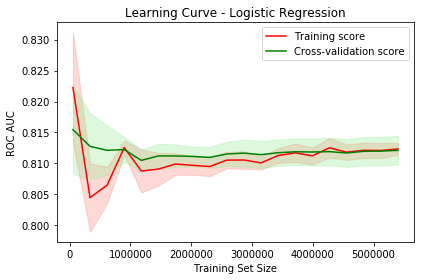

Wall time: 10min 13s


In [14]:
%%time
model_cv(x1, y1, lr_model, 'Logistic Regression')

In [15]:
lr_model.fit(x1, y1)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [23]:
print_cm_auc(lr_model, x3, y3)

Confusion matrix:
[[1555723  440700]
 [   1016    2561]]

AUROC:
0.8079160080319726


Já pela learning curve é possível ver que o modelo não é o indicado. A curva de validação não aumentou conforme o tamanho dos dados, pelo contrário, ela começou alta e foi abaixando.

Treinando o modelo e fazendo as previsões, é possível verificar que o score da AUROC ficou bem abaixo do obtido pelo XGBoost. Alterar os hyperparâmetros talvez não ajude porque esse é um algoritmo simples, então, pode ser que um modelo mais complexo ajude a melhorar esse score.

**Decision tree**

Aumentando um pouco mais a complexidade do modelo

In [26]:
dt_model = DecisionTreeClassifier(max_depth=4, 
                                  class_weight='balanced',
                                  min_samples_split=100,
                                  random_state=99)

[53999] train-roc_auc: 0.9476500826543799 valid-roc_auc: 0.8634136457126518
[335368] train-roc_auc: 0.9296854990713642 valid-roc_auc: 0.9152115451356402
[616736] train-roc_auc: 0.929195277357865 valid-roc_auc: 0.924403958759965
[898105] train-roc_auc: 0.9288271788380961 valid-roc_auc: 0.9270025285169073
[1179473] train-roc_auc: 0.9291213854269913 valid-roc_auc: 0.9286243351926068
[1460841] train-roc_auc: 0.9238713468533166 valid-roc_auc: 0.9233940171181946
[1742210] train-roc_auc: 0.9239030174361794 valid-roc_auc: 0.922968527871443
[2023578] train-roc_auc: 0.9223484291097039 valid-roc_auc: 0.9215333991439741
[2304946] train-roc_auc: 0.9219048675624014 valid-roc_auc: 0.9212651973027193
[2586315] train-roc_auc: 0.923234172197836 valid-roc_auc: 0.9231183433554644
[2867683] train-roc_auc: 0.9232802464224426 valid-roc_auc: 0.923409032719307
[3149052] train-roc_auc: 0.9224934375335505 valid-roc_auc: 0.923021937766819
[3430420] train-roc_auc: 0.9229301479170393 valid-roc_auc: 0.92323979198225

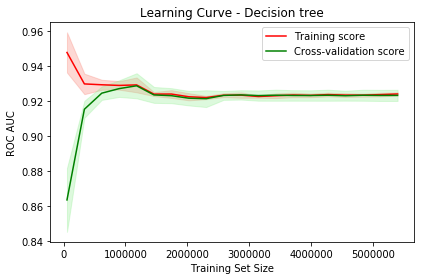

Wall time: 13min 6s


In [27]:
%%time

model_cv(x1, y1, dt_model, 'Decision tree')

In [28]:
dt_model.fit(x1, y1)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=99,
            splitter='best')

In [29]:
print_cm_auc(dt_model, x3, y3)

Confusion matrix:
[[1836942  159481]
 [    843    2734]]

AUROC:
0.9116937496220516


O modelo melhorou bastante e a quantidade de falsos positivos diminuiu também. A curva de validação sobe enquanto a de treino decai com a quantidade de dados. Essa é a curva padrão!

Entretanto, ainda parece que esse modelo não é o ideal. A partir de 1,2mi de registros parece que o modelo não precisa mais de dados para aprender. A literatura diz que é preciso haver um pequeno gap entre as curvas. Dessa forma ele pode generalizar bem novos dados. O resultado da predição não foi ruim, pelo contrário, foi o esperado pela cross validation feita antes. Esse é um comportamento típico de underfitting. Para contornar isso, podemos 1) alterar o algoritmo ou 2) tunar os hyperparametros.

**Random forest**

In [36]:
rf_model = RandomForestClassifier(n_estimators=10, 
                                  max_depth=4, 
                                  max_features=None, 
                                  min_samples_split=10, 
                                  class_weight='balanced', 
                                  random_state=99)

[47999] train-roc_auc: 0.9740281541358763 valid-roc_auc: 0.8942709110876926
[298105] train-roc_auc: 0.9403258401073482 valid-roc_auc: 0.930618290049772
[548210] train-roc_auc: 0.938244163594656 valid-roc_auc: 0.9358183795265935
[798315] train-roc_auc: 0.9368624635423662 valid-roc_auc: 0.9347679304062
[1048420] train-roc_auc: 0.934751030409856 valid-roc_auc: 0.9338455947886196
[1298526] train-roc_auc: 0.933757698312425 valid-roc_auc: 0.9345956857633685
[1548631] train-roc_auc: 0.9345806755095519 valid-roc_auc: 0.9347152633286021
[1798736] train-roc_auc: 0.9323081279120681 valid-roc_auc: 0.9324577111304134
[2048841] train-roc_auc: 0.9309241891267902 valid-roc_auc: 0.9308406536249674
[2298946] train-roc_auc: 0.9329234964630366 valid-roc_auc: 0.93347069900374
[2549052] train-roc_auc: 0.9334838182146051 valid-roc_auc: 0.9345567326635326
[2799157] train-roc_auc: 0.9328129533143491 valid-roc_auc: 0.9330750878606954
[3049262] train-roc_auc: 0.9354789342460959 valid-roc_auc: 0.9352460313762198


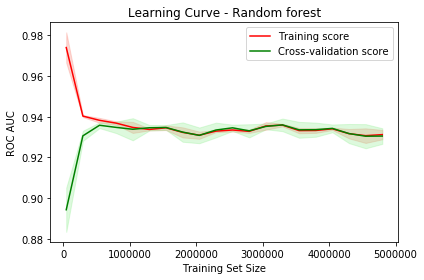

In [37]:
model_cv(x1, y1, rf_model, 'Random forest', n_jobs=3, cv=3)

In [38]:
rf_model.fit(x1, y1)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=4, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=99,
            verbose=0, warm_start=False)

In [39]:
print_cm_auc(rf_model, x3, y3)

Confusion matrix:
[[1836956  159467]
 [    843    2734]]

AUROC:
0.9171608159101414


Da mesma forma que o a Decision tree, o Random forest também parece precisar de mais complexidade para melhorar. A desvantagem perante Decision tree é a velocidade do algoritmo que é muito mais lenta.

**XGBoost (com a API do sklearn)**

In [9]:
xgb_model = xgb.XGBClassifier(eta= 0.1, 
                              max_depth= 4, 
                              subsample= 0.9, 
                              colsample_bytree= 0.7, 
                              colsample_bylevel=0.7,
                              min_child_weight=100,
                              alpha=4,
                              objective= 'binary:logistic', 
                              eval_metric= 'auc', 
                              random_state= 99, 
                              scale_pos_weight= 557,
                              silent= True,
                              n_jobs=-1)

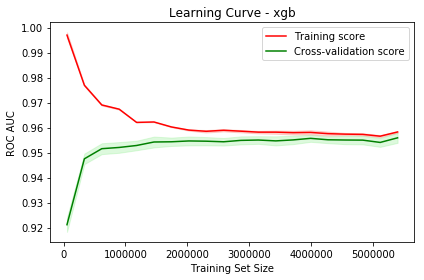

In [77]:
model_cv(x1, y1, xgb_model, 'xgb')

In [10]:
xgb_model.fit(x1, y1)

[14:01:49] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'


XGBClassifier(alpha=4, base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7, colsample_bytree=0.7, eta=0.1,
       eval_metric='auc', gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=100, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=99, reg_alpha=0, reg_lambda=1, scale_pos_weight=557,
       seed=None, silent=True, subsample=0.9)

In [16]:
print_cm_auc(xgb_model, x3, y3)

Confusion matrix:


C:\Users\Mark\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[1872587  123836]
 [    932    2645]]

AUROC:
0.929662042679631


Essa é a curva padrão de aprendizagem. Esse é modelo a ser explorado. Conseguimos isso fazendo 2 coisas: usando o XGoost e alterando os hyperparametros(pegos do fórum do Kaggle). Nota-se que há um gap pequeno entre as duas curvas e que o modelo aprende com os dados de forma contínua generalizando o modelo para dados novos.

Falsos positivos também possuem um valor aceitável de pouco mais de 5%.